# Social Media Ads Sales Forecasting
Objectives: Sales forecasts based on social media platforms, and suggest budget allocation given $100k budget

* [Scrub Data](#scrub)
* EDA - [Heatmap](#heatmap)
* EDA - [Regplot and Histogram](#regplot)
* [Simple Linear Regression](#reg) - Comparison between Google/FB/IG
* [Multiple Linear Regression](#multi) - Overall Model
* [Sales Simulation](#sales)


In [1674]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [1675]:
df = pd.read_excel('https://github.com/abbylmm/DS_Uncut/blob/main/social-ads-raw.xlsx?raw=true', index_col='segment')
df.sample(5)

,google,facebook,instagram,sales,size,area
segment,,,,,,
29,248.8,27.1,22.9,18.9,large,suburban
166,234.5,3.4,84.8,11.9,large,rural
50,66.9,11.7,36.8,9.7,small,rural
7,57.5,32.8,23.5,11.8,large,suburban
54,182.6,46.2,58.7,21.2,large,suburban


<a id='scrub'></a>
# Scrub Data

In [1676]:
categorical_columns = df.loc[:,['size', 'area']].columns.tolist()

# print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of variable: %s'%col)
    print (df[col].value_counts())


Frequency of variable: size
large    108
small     92
Name: size, dtype: int64

Frequency of variable: area
suburban    78
urban       63
rural       59
Name: area, dtype: int64


In [1677]:
df['islarge'] = df['size'].map({'small': 0, 'large': 1})

In [1678]:
df2 = pd.get_dummies(df, prefix={'area':'area'}, columns=['area'])
df3 = df2.drop(['size'], axis=1)
df3.head()

,google,facebook,instagram,sales,islarge,area_rural,area_suburban,area_urban
segment,,,,,,,,
1,230.1,37.8,69.2,22.1,1,1,0,0
2,44.5,39.3,45.1,10.4,0,0,0,1
3,17.2,45.9,69.3,9.3,0,1,0,0
4,151.5,41.3,58.5,18.5,0,0,0,1
5,180.8,10.8,58.4,12.9,1,0,1,0


In [1679]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   google         200 non-null    float64
 1   facebook       200 non-null    float64
 2   instagram      200 non-null    float64
 3   sales          200 non-null    float64
 4   islarge        200 non-null    int64  
 5   area_rural     200 non-null    uint8  
 6   area_suburban  200 non-null    uint8  
 7   area_urban     200 non-null    uint8  
dtypes: float64(4), int64(1), uint8(3)
memory usage: 10.0 KB


# Explore Data

<a id='heatmap'></a>
### Heatmap

C:\Users\munmun\AppData\Local\Temp/ipykernel_18192/3958557817.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


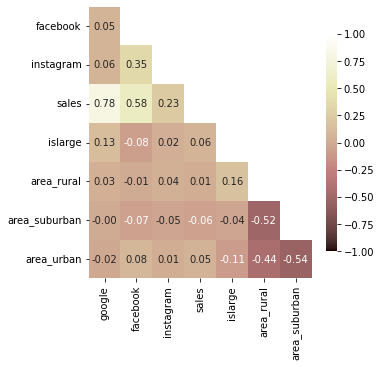

In [1680]:
fig, ax = plt.subplots(figsize=(5, 5))

corr = df3.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="pink", vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.show()

Text(0.5, 1.0, 'Correlation with Sales')

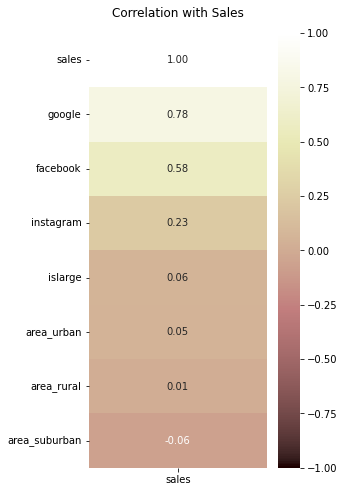

In [1681]:
plt.figure(figsize=(4, 8))
heatmap = sns.heatmap(df3.corr()[['sales']].sort_values(by='sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='pink',fmt=".2f")
heatmap.set_title('Correlation with Sales', fontdict={'fontsize':12}, pad=16)

<a id='regplot'></a>
### Regplot and Histogram

<AxesSubplot:ylabel='Frequency'>

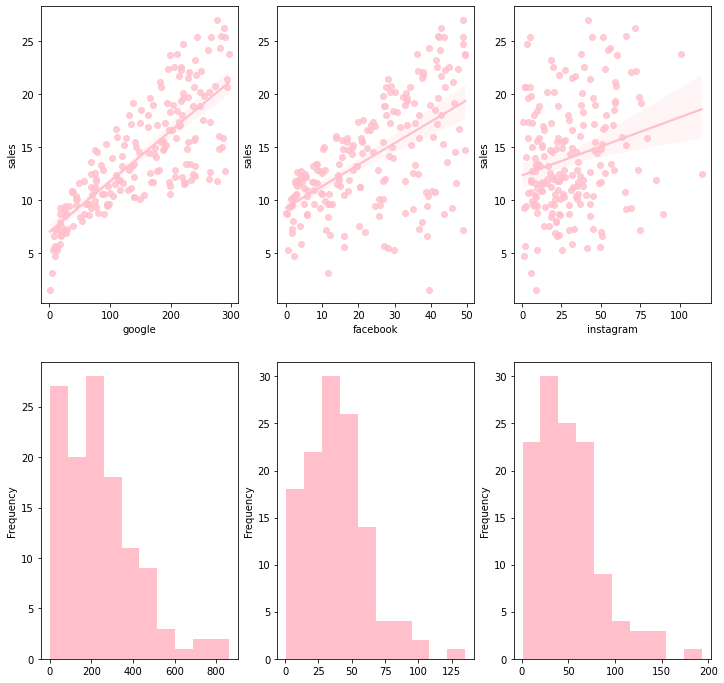

In [1682]:
fig, subs = plt.subplots(2, 3, figsize=(12,12))

sns.regplot(data=df3, x="google", y="sales", color="pink", ax=subs[0,0])
sns.regplot(data=df3, x="facebook", y="sales", color="pink", ax=subs[0,1])
sns.regplot(data=df3, x="instagram", y="sales", color="pink", ax=subs[0,2])

gg = df3.groupby(['sales'])['google'].sum().reset_index()
fb = df3.groupby(['sales'])['facebook'].sum().reset_index()
ig = df3.groupby(['sales'])['instagram'].sum().reset_index()

gg['google'].plot(kind='hist', color="pink", ax=subs[1,0])
fb['facebook'].plot(kind='hist', color="pink", ax=subs[1,1])
ig['instagram'].plot(kind='hist', color="pink", ax=subs[1,2])

* The greater the magnitude of the slope, the steeper the line, the greater the rate of change
* Google >>> Facebook >>> Instagram

In [1683]:
Google = df3['google'].sum() / df3['sales'].sum()
Facebook = df3['facebook'].sum() / df3['sales'].sum()
Instagram = df3['instagram'].sum() / df3['sales'].sum()

print("Google ads spent per unit sold:", f"{Google:.2f}")
print("Facebook ads spent per unit sold:", f"{Facebook:.2f}")
print("Instagram ads spent per unit sold:", f"{Instagram:.2f}")

Google ads spent per unit sold: 10.49
Facebook ads spent per unit sold: 1.66
Instagram ads spent per unit sold: 2.18


Costs in ads spent in order to sell a unit: 
* Given a thousand units, Google is most expensive with $10.49 thousand spent, followed by Instagram and Facebook
* Google >>> Instagram >>> Facebook

<a id='reg'></a>
# Simple Linear Regression

Comparison between performance of Google / Facebook / Instagram

In [1684]:
from sklearn.linear_model import LinearRegression
y = df3['sales']

In [1685]:
X1 = df3[['google']]
X2 = df3[['facebook']]
X3 = df3[['instagram']]

X = [X1, X2, X3]

# predict_value
n = 100

unit_price = 5000

for i in range(3):
    reg = LinearRegression()
    reg.fit(X[i].values, y)
    R2 = reg.score(X[i].values, y)
    predict = reg.predict([[n]])
    revenue = predict[0] * 1000 * unit_price

    if i == 0:
       print("\n Google")
       print("R-square:", "{:.2%}".format(R2))
       print("Intercept:", reg.intercept_)
       print("Coefficient:", reg.coef_[0])
       print("Every", n, "thousand amount spent in ads yields", "{:.2f}".format(predict[0]), "thousand units sold")
       print("Total Revenue:", "${:,.0f}".format(revenue))
    elif i == 1:
       print("\n Facebook")
       print("R-square:", "{:.2%}".format(R2))
       print("Intercept:", reg.intercept_)
       print("Coefficient:", reg.coef_[0])
       print("Every", n, "thousand amount spent in ads yields", "{:.2f}".format(predict[0]), "thousand units sold")
       print("Total Revenue:", "${:,.0f}".format(revenue))
    elif i == 2:
       print("\n Instagram")
       print("R-square:", "{:.2%}".format(R2))
       print("Intercept:", reg.intercept_)
       print("Coefficient:", reg.coef_[0])
       print("Every", n, "thousand amount spent in ads yields", "{:.2f}".format(predict[0]), "thousand units sold")
       print("Total Revenue:", "${:,.0f}".format(revenue))


 Google
R-square: 61.19%
Intercept: 7.032593549127695
Coefficient: 0.04753664043301975
Every 100 thousand amount spent in ads yields 11.79 thousand units sold
Total Revenue: $58,931,288

 Facebook
R-square: 33.20%
Intercept: 9.311638095158283
Coefficient: 0.20249578339243965
Every 100 thousand amount spent in ads yields 29.56 thousand units sold
Total Revenue: $147,806,082

 Instagram
R-square: 5.21%
Intercept: 12.35140706927816
Coefficient: 0.05469309847227336
Every 100 thousand amount spent in ads yields 17.82 thousand units sold
Total Revenue: $89,103,585


* With the same amount spent in ads, sales generating follow by: 
* Facebook >>> Instagram >>> Google

<a id='multi'></a>
# Multiple Linear Regression

Overall Model

In [1686]:
selected_feat = ['facebook', 'instagram', 'google', 'islarge', 'area_urban', 'area_suburban', 'area_rural']
X = df3[selected_feat].values

model = LinearRegression()
model.fit(X, y)
R2 = model.score(X, y)
print("R-square:", "{:.2%}".format(R2))


R-square: 89.82%


In [1687]:
summary_table = pd.DataFrame(columns=['Features'], data=selected_feat)
summary_table['Coefficient'] = np.transpose(model.coef_)
summary_table['Intercept'] = model.intercept_
summary_table

,Features,Coefficient,Intercept
0,facebook,0.187867,2.928049
1,instagram,-0.001088,2.928049
2,google,0.045744,2.928049
3,islarge,0.077397,2.928049
4,area_urban,0.214280,2.928049
5,area_suburban,-0.160421,2.928049
6,area_rural,-0.053858,2.928049


In [1688]:
summary_table['Odds_Ratio'] = np.exp(summary_table.Coefficient)
summary_table.sort_values('Odds_Ratio', ascending=False)

,Features,Coefficient,Intercept,Odds_Ratio
4,area_urban,0.214280,2.928049,1.238969
0,facebook,0.187867,2.928049,1.206673
3,islarge,0.077397,2.928049,1.080471
2,google,0.045744,2.928049,1.046806
1,instagram,-0.001088,2.928049,0.998913
6,area_rural,-0.053858,2.928049,0.947566
5,area_suburban,-0.160421,2.928049,0.851785


* Instagram has a negative coefficient towards units sold, which is not effective in generating revenues
* Google is most expensive and less effective compared with Facebook
* Facebook is most effective and cheaper compared with Google

In [1689]:
model.predict([[30, 20, 50, 0, 1, 0, 0]])

array([11.04377644])

<a id='sales'></a>
# Sales Simulation

Given budget $100,000, how would you allocate your budget to maximize revenue?

In [1690]:
# Budget $100k thousand

import random
gg_rd = list(random.sample(range(0, 100, 1), 100))

fb_rd = []
for i in range(len(gg_rd)):
    fb_rd.append(random.randrange(0, 100-gg_rd[i], 1))

In [1691]:
rd_df = pd.DataFrame(gg_rd)
rd_df.rename(columns={0: 'google'}, inplace=True)

rd_df1 = pd.DataFrame(fb_rd)
rd_df1.rename(columns={0: 'facebook'}, inplace=True)

rd_df2 = rd_df.join(rd_df1)
rd_df2['instagram'] = 100-rd_df2[['google', 'facebook']].sum(1).astype(int)

rd_df2['islarge'] = 1
rd_df2['area_urban'] = 1
rd_df2['area_suburban'] = 0
rd_df2['area_rural'] = 0

newdf = rd_df2[['facebook', 'instagram', 'google', 'islarge', 'area_urban', 'area_suburban', 'area_rural']]


In [1692]:
unit_price = 5000

y_head = model.predict(newdf)
predictdf = pd.DataFrame({'Expected_Units_Sold': y_head})

newdf2 = newdf.join(predictdf)
newdf2['Expected_Revenue'] = newdf2['Expected_Units_Sold'] * 1000 * unit_price

sorted_df = newdf2.sort_values(by=['Expected_Revenue'], ascending=False)
sorted_df.style.format({'Expected_Units_Sold': "{:,.2f}", 'Expected_Revenue': "$ {:,.0f}"})


C:\Users\munmun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,facebook,instagram,google,islarge,area_urban,area_suburban,area_rural,Expected_Units_Sold,Expected_Revenue
67,91,1,8,1,1,0,0,20.68,"$ 103,402,296"
63,83,4,13,1,1,0,0,19.40,"$ 97,014,913"
8,77,5,18,1,1,0,0,18.50,"$ 92,517,074"
24,78,13,9,1,1,0,0,18.27,"$ 91,354,419"
50,74,7,19,1,1,0,0,17.98,"$ 89,916,917"
25,78,20,2,1,1,0,0,17.94,"$ 89,715,310"
47,73,23,4,1,1,0,0,17.09,"$ 85,459,767"
91,65,4,31,1,1,0,0,16.84,"$ 84,223,872"
34,69,17,14,1,1,0,0,16.80,"$ 84,022,264"
19,56,3,41,1,1,0,0,15.61,"$ 78,062,509"
